## This Notebook contains Neural Network having Single Input and Multiple Outputs

In [1]:
# import the necessary packages
from tensorflow.keras.models import Model
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Lambda
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
import tensorflow as tf

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

import cv2

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.use("Agg")

import imutils
from imutils import paths
import pickle
import random
import os

# Data Preparation

In [2]:
Path = os.getcwd() + "\\dataset"
Path

'C:\\Users\\Waqas Ahmed\\Downloads\\Compressed\\multi-output-classification\\multi-output-classification\\dataset'

In [3]:
# grab the image paths and randomly shuffle them
imagePaths = sorted(list(paths.list_images(Path)))
random.seed(42)
random.shuffle(imagePaths)
imagePaths[0]

'C:\\Users\\Waqas Ahmed\\Downloads\\Compressed\\multi-output-classification\\multi-output-classification\\dataset\\black_shoes\\00000260.jpg'

In [4]:
# initialize the data, clothing category labels (i.e., shirts, jeans,
# dresses, etc.) along with the color labels (i.e., red, blue, etc.)
data = []
categoryLabels = []
colorLabels = []

In [5]:
IMAGE_DIMS = (96, 96, 3)
# loop over the input images
for imagePath in imagePaths:
	# load the image, pre-process it, and store it in the data list
	image = cv2.imread(imagePath)
	image = cv2.resize(image, (IMAGE_DIMS[1], IMAGE_DIMS[0]))
	image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
	image = img_to_array(image)
	data.append(image)

	# extract the clothing color and category from the path and
	# update the respective lists
	(color, cat) = imagePath.split(os.path.sep)[-2].split("_")
	categoryLabels.append(cat)
	colorLabels.append(color)

In [6]:
data[0].shape

(96, 96, 3)

In [7]:
categoryLabels[0]

'shoes'

In [8]:
colorLabels[0]

'black'

In [9]:
# scale the raw pixel intensities to the range [0, 1] and convert to
# a NumPy array
data = np.array(data, dtype="float32") / 255.0
print("[INFO] data matrix: {} images ({:.2f}MB)".format(len(imagePaths), data.nbytes / (1024 * 1000.0)))

[INFO] data matrix: 2521 images (272.27MB)


In [10]:
# convert the label lists to NumPy arrays prior to binarization
categoryLabels = np.array(categoryLabels)
colorLabels = np.array(colorLabels)

# binarize both sets of labels
categoryLB = LabelBinarizer()
colorLB = LabelBinarizer()
categoryLabels = categoryLB.fit_transform(categoryLabels)
colorLabels = colorLB.fit_transform(colorLabels)

In [11]:
# partition the data into training and testing splits using 80% of
# the data for training and the remaining 20% for testing
split = train_test_split(data, categoryLabels, colorLabels,test_size=0.2, random_state=42)
(trainX, testX, trainCategoryY, testCategoryY,trainColorY, testColorY) = split

# Model Development

In [12]:
class FashionNet:
    
    @staticmethod
    def build_category_branch(inputs, numCategories,finalAct="softmax", chanDim=-1):
        # utilize a lambda layer to convert the 3 channel input to a
        # grayscale representation
        x = Lambda(lambda c: tf.image.rgb_to_grayscale(c))(inputs)

        # CONV => RELU => POOL
        x = Conv2D(32, (3, 3), padding="same")(x)
        x = Activation("relu")(x)
        x = BatchNormalization(axis=chanDim)(x)
        x = MaxPooling2D(pool_size=(3, 3))(x)
        x = Dropout(0.25)(x)

        # (CONV => RELU) * 2 => POOL
        x = Conv2D(64, (3, 3), padding="same")(x)
        x = Activation("relu")(x)
        x = BatchNormalization(axis=chanDim)(x)
        x = Conv2D(64, (3, 3), padding="same")(x)
        x = Activation("relu")(x)
        x = BatchNormalization(axis=chanDim)(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)
        x = Dropout(0.25)(x)

        # (CONV => RELU) * 2 => POOL
        x = Conv2D(128, (3, 3), padding="same")(x)
        x = Activation("relu")(x)
        x = BatchNormalization(axis=chanDim)(x)
        x = Conv2D(128, (3, 3), padding="same")(x)
        x = Activation("relu")(x)
        x = BatchNormalization(axis=chanDim)(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)
        x = Dropout(0.25)(x)

        # define a branch of output layers for the number of different
        # clothing categories (i.e., shirts, jeans, dresses, etc.)
        x = Flatten()(x)
        x = Dense(256)(x)
        x = Activation("relu")(x)
        x = BatchNormalization()(x)
        x = Dropout(0.5)(x)
        x = Dense(numCategories)(x)
        x = Activation(finalAct, name="category_output")(x)

        # return the category prediction sub-network
        return x

    @staticmethod
    def build_color_branch(inputs, numColors, finalAct="softmax",chanDim=-1):
        # CONV => RELU => POOL
        x = Conv2D(16, (3, 3), padding="same")(inputs)
        x = Activation("relu")(x)
        x = BatchNormalization(axis=chanDim)(x)
        x = MaxPooling2D(pool_size=(3, 3))(x)
        x = Dropout(0.25)(x)

        # CONV => RELU => POOL
        x = Conv2D(32, (3, 3), padding="same")(x)
        x = Activation("relu")(x)
        x = BatchNormalization(axis=chanDim)(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)
        x = Dropout(0.25)(x)

        # CONV => RELU => POOL
        x = Conv2D(32, (3, 3), padding="same")(x)
        x = Activation("relu")(x)
        x = BatchNormalization(axis=chanDim)(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)
        x = Dropout(0.25)(x)

        # define a branch of output layers for the number of different
        # colors (i.e., red, black, blue, etc.)
        x = Flatten()(x)
        x = Dense(128)(x)
        x = Activation("relu")(x)
        x = BatchNormalization()(x)
        x = Dropout(0.5)(x)
        x = Dense(numColors)(x)
        x = Activation(finalAct, name="color_output")(x)

        # return the color prediction sub-network
        return x

    @staticmethod
    def build(width, height, numCategories, numColors, finalAct="softmax"):
        # initialize the input shape and channel dimension (this code
        # assumes you are using TensorFlow which utilizes channels
        # last ordering)
        inputShape = (height, width, 3)
        chanDim = -1

        # construct both the "category" and "color" sub-networks
        inputs = Input(shape=inputShape)
        categoryBranch = FashionNet.build_category_branch(inputs, numCategories, finalAct=finalAct, chanDim=chanDim)
        colorBranch = FashionNet.build_color_branch(inputs, numColors, finalAct=finalAct, chanDim=chanDim)

        # create the model using our input (the batch of images) and
        # two separate outputs -- one for the clothing category
        # branch and another for the color branch, respectively
        model = Model(
            inputs=inputs,
            outputs=[categoryBranch, colorBranch],
            name="fashionnet")

        # return the constructed network architecture
        return model

In [13]:
# initialize our FashionNet multi-output network
model = FashionNet.build(96, 96,
                         numCategories=len(categoryLB.classes_),
                         numColors=len(colorLB.classes_),
                         finalAct="softmax")

In [14]:
#model.summary()

In [15]:
# define two dictionaries: one that specifies the loss method for
# each output of the network along with a second dictionary that
# specifies the weight per loss
losses = {
    "category_output": "categorical_crossentropy",
    "color_output": "categorical_crossentropy",
}
lossWeights = {
    "category_output": 1.0, 
    "color_output": 1.0
}

In [20]:
# initialize the number of epochs to train for, initial learning rate,
# batch size, and image dimensions
EPOCHS = 10
INIT_LR = 1e-3
BS = 32
IMAGE_DIMS = (96, 96, 3)

In [21]:
# initialize the optimizer and compile the model
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(optimizer=opt, loss=losses, loss_weights=lossWeights,metrics=["accuracy"])

In [22]:
# train the network to perform multi-output classification
EPOCHS = 10
H = model.fit(trainX,
    {"category_output": trainCategoryY, "color_output": trainColorY},
    validation_data=(testX, {"category_output": testCategoryY, "color_output": testColorY}),
    epochs=EPOCHS)

Train on 2016 samples, validate on 505 samples
Epoch 1/10
2016/2016 [==============================] - 6s 3ms/sample - loss: 0.1769 - category_output_loss: 0.1233 - color_output_loss: 0.0536 - category_output_accuracy: 0.9573 - color_output_accuracy: 0.9836 - val_loss: 0.4354 - val_category_output_loss: 0.3188 - val_color_output_loss: 0.1177 - val_category_output_accuracy: 0.9327 - val_color_output_accuracy: 0.9525
Epoch 2/10
2016/2016 [==============================] - 3s 2ms/sample - loss: 0.1931 - category_output_loss: 0.1567 - color_output_loss: 0.0364 - category_output_accuracy: 0.9534 - color_output_accuracy: 0.9866 - val_loss: 3.6594 - val_category_output_loss: 3.5174 - val_color_output_loss: 0.1509 - val_category_output_accuracy: 0.6020 - val_color_output_accuracy: 0.9545
Epoch 3/10
2016/2016 [==============================] - 3s 2ms/sample - loss: 0.1836 - category_output_loss: 0.1361 - color_output_loss: 0.0475 - category_output_accuracy: 0.9559 - color_output_accuracy: 0.983

### Saving model, data, reports

In [23]:
# save the model to disk 
model.save("FashionNet_Model")

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: FashionNet_Model\assets


In [24]:
# save the category binarizer to disk 
f = open("category_binarizer", "wb")
f.write(pickle.dumps(categoryLB))
f.close()

In [25]:
# save the color binarizer to disk
f = open("color_binarizer", "wb")
f.write(pickle.dumps(colorLB))
f.close()

In [26]:
# plot the total loss, category loss, and color loss
lossNames = ["loss", "category_output_loss", "color_output_loss"]
plt.style.use("ggplot")
(fig, ax) = plt.subplots(3, 1, figsize=(13, 13))

# loop over the loss names
for (i, l) in enumerate(lossNames):
    # plot the loss for both the training and validation data
    title = "Loss for {}".format(l) if l != "loss" else "Total loss"
    ax[i].set_title(title)
    ax[i].set_xlabel("Epoch #")
    ax[i].set_ylabel("Loss")
    ax[i].plot(np.arange(0, EPOCHS), H.history[l], label=l)
    ax[i].plot(np.arange(0, EPOCHS), H.history["val_" + l],label="val_" + l)
    ax[i].legend()
    
# save the losses figure
plt.tight_layout()
plt.savefig("losses.png")
plt.close()

### Loading data and model

In [28]:
model = load_model("FashionNet_Model", custom_objects={"tf": tf})
categoryLB = pickle.loads(open("category_binarizer", "rb").read())
colorLB = pickle.loads(open("color_binarizer", "rb").read())

### Test any image

In [29]:
# load the image
Path = os.getcwd()+"\\examples\\red_shirt.jpg" 
image = cv2.imread(Path)

In [30]:
output = imutils.resize(image, width=400)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

In [31]:
# pre-process the image for classification
image = cv2.resize(image, (96, 96))
image = image.astype("float") / 255.0
image = img_to_array(image)
image = np.expand_dims(image, axis=0)

In [32]:
(categoryProba, colorProba) = model.predict(image)

In [33]:
# find indexes of both the category and color outputs with the
# largest probabilities, then determine the corresponding class
# labels
categoryIdx = categoryProba[0].argmax()
colorIdx = colorProba[0].argmax()
categoryLabel = categoryLB.classes_[categoryIdx]
colorLabel = colorLB.classes_[colorIdx]

In [34]:
# draw the category label and color label on the image
categoryText = "category: {} ({:.2f}%)".format(categoryLabel,
    categoryProba[0][categoryIdx] * 100)
colorText = "color: {} ({:.2f}%)".format(colorLabel,
    colorProba[0][colorIdx] * 100)
cv2.putText(output, categoryText, (10, 25), cv2.FONT_HERSHEY_SIMPLEX,
    0.7, (0, 255, 0), 2)
cv2.putText(output, colorText, (10, 55), cv2.FONT_HERSHEY_SIMPLEX,
    0.7, (0, 255, 0), 2)
# show the output image
cv2.imshow("Output", output)
cv2.waitKey(0)
cv2.destroyAllWindows()
cv2.waitKey(1)

-1

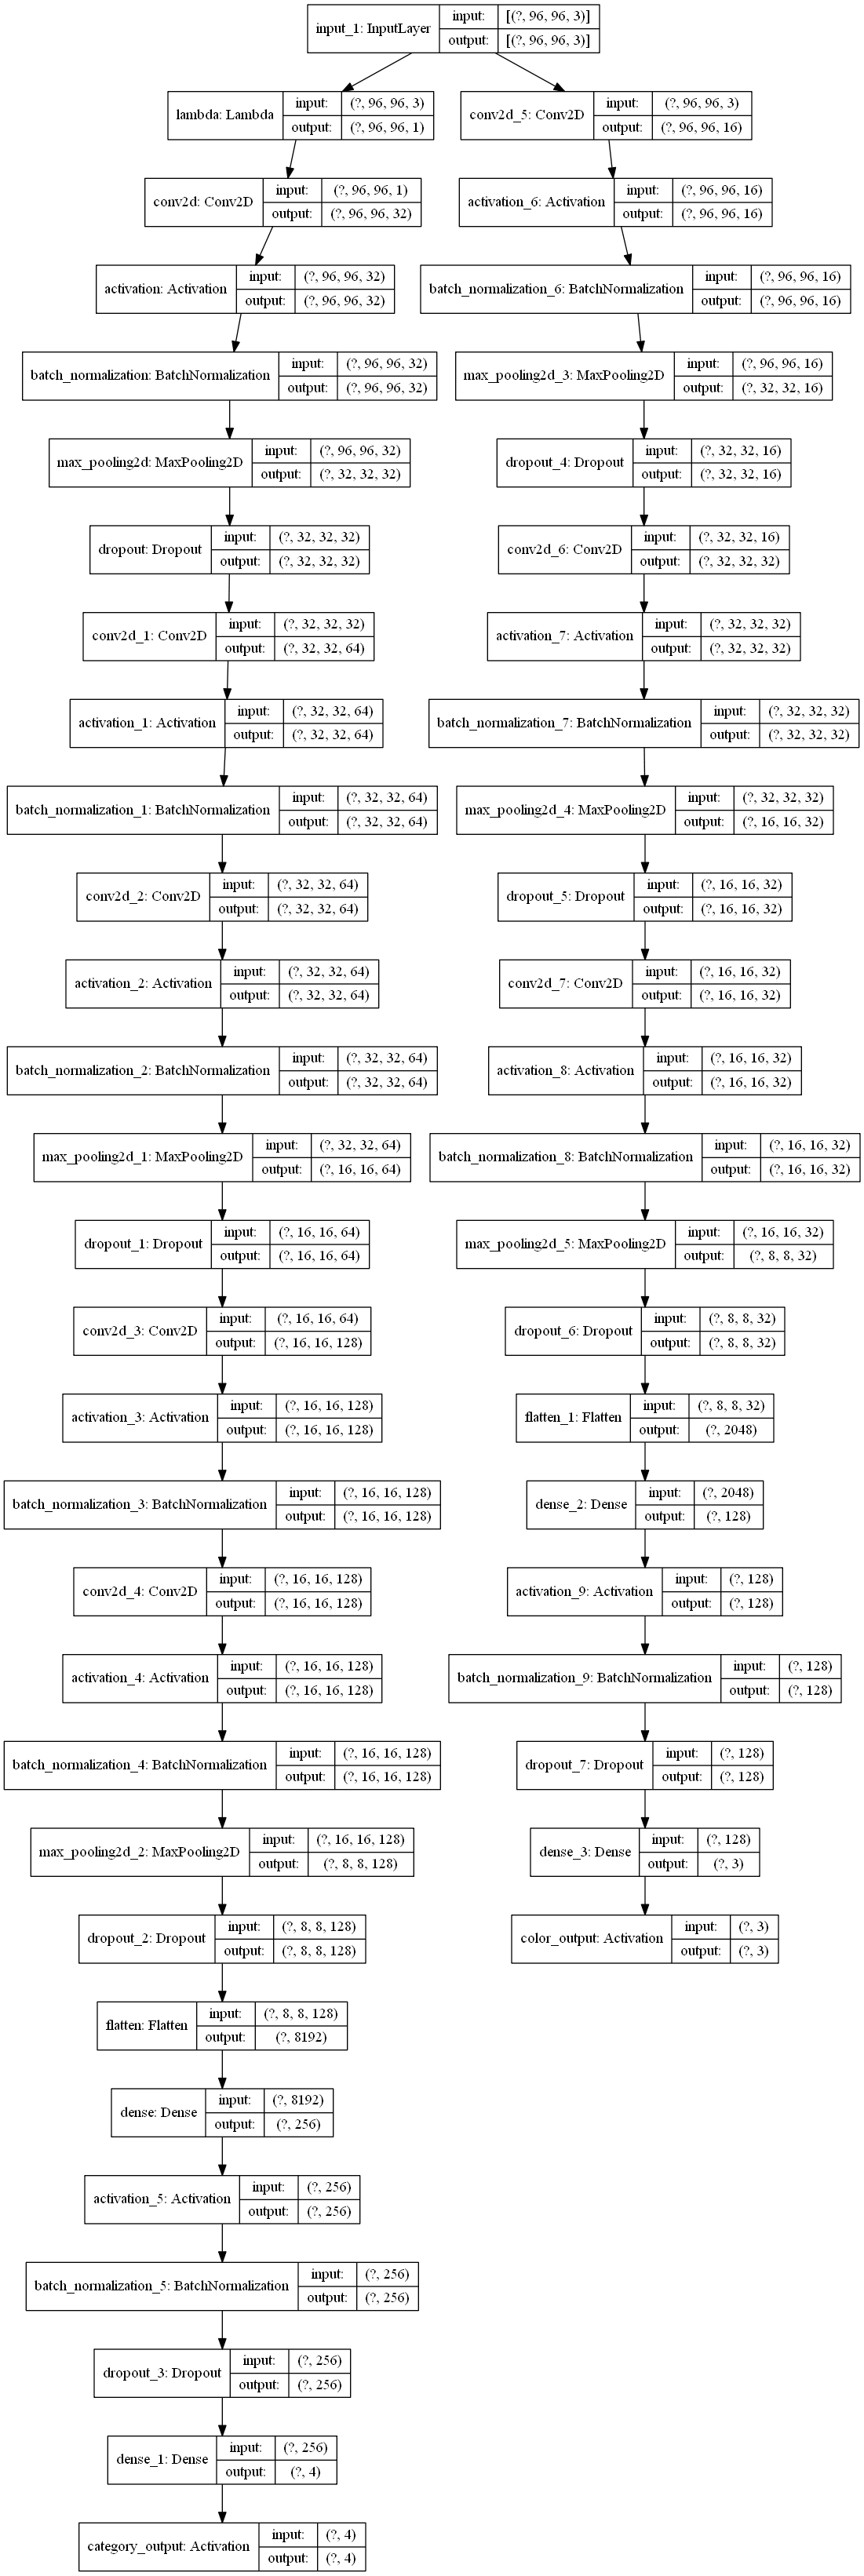

In [35]:
dot_img_file = 'MultiOutput_Model.png'
tf.keras.utils.plot_model(model, to_file=dot_img_file, show_shapes=True)